1.Independent Variable Cleaning and Visualization

In [7]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.linear_model import LinearRegression
import statsmodels
import statsmodels.api as sm

import numpy as np

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import seaborn as sn

1.1 Calculation of racial share, racial segregation index

In [2]:
# Reading lsoa race CSV files
df = pd.read_csv('Ethnic group.csv')

df['White'] = df['White British'] + df['White Irish'] + df['White Gypsy/Irish Traveller'] + df['White Roma'] + df['White Other']

df['Mixed'] = df['Mixed White and Asian'] + df['Mixed White and Black African'] + df['Mixed White and Black Caribbean'] + df['Mixed Other']

df['Asian'] = df['Asian Bangladeshi'] + df['Asian Chinese'] + df['Asian Indian'] + df['Asian Pakistani'] + df['Asian Other']

df['Black'] = df['Black African'] + df['Black Caribbean'] + df['Black Other']

df['Other'] = df['Other Arab'] + df['Other Any other']
# Calculating lsoa racial share
df['White Ratio'] = df['White'] / df['All usual residents']
df['Mixed Ratio'] = df['Mixed'] / df['All usual residents']
df['Asian Ratio'] = df['Asian'] / df['All usual residents']
df['Black Ratio'] = df['Black'] / df['All usual residents']
df['Other Ratio'] = df['Other'] / df['All usual residents']

print(df.head())

   LSOA code local authority name local authority code  All usual residents  \
0  E01000001       City of London            E09000001                 1473   
1  E01000002       City of London            E09000001                 1384   
2  E01000003       City of London            E09000001                 1608   
3  E01000005       City of London            E09000001                 1104   
4  E01032739       City of London            E09000001                 1622   

   White British  White Irish  White Gypsy/Irish Traveller  White Roma  \
0            822           31                            0          11   
1            735           42                            0           6   
2            813           32                            0           4   
3            259           20                            0           6   
4            564           27                            0          22   

   White Other  Mixed White and Asian  ...  White  Mixed  Asian  Black  Other  \

In [3]:
# Read SHP files for LSOA
lsoa_shp = 'LSOA_2011_London_gen_MHW.shp'
lsoa_gdf = gpd.read_file(lsoa_shp)

In [4]:
# Merge results into LSOA GeoDataFrame
lsoa_gdf = lsoa_gdf.merge(df, left_on='LSOA11CD', right_on='LSOA code')

In [8]:
# Racial segregation calculates entropy
def calculate_entropy(row, race_columns):
    entropy = 0
    for col in race_columns:
        p_i = row[col]
        if p_i > 0:  
            entropy += -p_i * np.log(p_i)
    return entropy

# Defining the racial scale column
race_columns = ['White Ratio', 'Mixed Ratio', 'Asian Ratio', 'Black Ratio', 'Other Ratio']

# Calculate entropy (multiracial segregation index) for each LSOA
lsoa_gdf['entropy2'] = lsoa_gdf.apply(calculate_entropy, axis=1, race_columns=race_columns)

# View Results
print(lsoa_gdf[['LSOA11CD', 'entropy2']].head())

    LSOA11CD  entropy2
0  E01000001  0.715827
1  E01000002  0.743939
2  E01000003  0.915719
3  E01000005  1.406362
4  E01000006  1.229521


1.2 Economic Index

In [9]:
# Read economic CSV file
deprivation_df = pd.read_csv('deprivation.csv')
deprivation_df.rename(columns={'LSOA code (2011)': 'LSOA11CD'}, inplace=True)

In [10]:
# Merging data sets
lsoa_gdf = lsoa_gdf.merge(deprivation_df, on='LSOA11CD', how='left')
# View the first few lines of the merge result
print(lsoa_gdf.head())

    LSOA11CD                   LSOA11NM   MSOA11CD                  MSOA11NM  \
0  E01000001        City of London 001A  E02000001        City of London 001   
1  E01000002        City of London 001B  E02000001        City of London 001   
2  E01000003        City of London 001C  E02000001        City of London 001   
3  E01000005        City of London 001E  E02000001        City of London 001   
4  E01000006  Barking and Dagenham 016A  E02000017  Barking and Dagenham 016   

     LAD11CD               LAD11NM    RGN11CD RGN11NM  USUALRES  HHOLDRES  \
0  E09000001        City of London  E12000007  London      1465      1465   
1  E09000001        City of London  E12000007  London      1436      1436   
2  E09000001        City of London  E12000007  London      1346      1250   
3  E09000001        City of London  E12000007  London       985       985   
4  E09000002  Barking and Dagenham  E12000007  London      1703      1699   

   ...  Other Ratio  entropy2  Index of Multiple Depriva

1.3  Calculating urban centrality

In [11]:
# Read zone CSV file
lsoa_zone_df = pd.read_csv('lsoa zone.csv')

In [12]:
# Fill in the missing values to the default Zone 6
lsoa_zone_df['Name'] = lsoa_zone_df['Name'].fillna('Zone 6')

# Extract Zone numbers and convert to integers
lsoa_zone_df['Zone Number'] = lsoa_zone_df['Name'].str.extract(r'(\d+)').astype(int)


# Calculate centrality (e.g., centrality can be inversely proportional to Zone number, i.e., the smaller the Zone number, the higher the centrality)
# The simple way is to use 1 / Zone_Number as the centrality
lsoa_zone_df['Centrality'] = 1 / lsoa_zone_df['Zone Number']

# View Results
print(lsoa_zone_df[['Name', 'Zone Number', 'Centrality']].head())

     Name  Zone Number  Centrality
0  Zone 1            1         1.0
1  Zone 1            1         1.0
2  Zone 1            1         1.0
3  Zone 1            1         1.0
4  Zone 1            1         1.0


In [13]:
# Extract the required columns
lsoa_zone_selected = lsoa_zone_df[['lsoa_id', 'Zone Number', 'Centrality']]
lsoa_zone_selected.rename(columns={'lsoa_id': 'LSOA11CD'}, inplace=True)
# Merge lsoa_zone_selected to lsoa_gdf
lsoa_gdf = lsoa_gdf.merge(lsoa_zone_selected, on='LSOA11CD', how='left')
# View merged data
print(lsoa_gdf.head())

    LSOA11CD                   LSOA11NM   MSOA11CD                  MSOA11NM  \
0  E01000001        City of London 001A  E02000001        City of London 001   
1  E01000002        City of London 001B  E02000001        City of London 001   
2  E01000003        City of London 001C  E02000001        City of London 001   
3  E01000005        City of London 001E  E02000001        City of London 001   
4  E01000006  Barking and Dagenham 016A  E02000017  Barking and Dagenham 016   

     LAD11CD               LAD11NM    RGN11CD RGN11NM  USUALRES  HHOLDRES  \
0  E09000001        City of London  E12000007  London      1465      1465   
1  E09000001        City of London  E12000007  London      1436      1436   
2  E09000001        City of London  E12000007  London      1346      1250   
3  E09000001        City of London  E12000007  London       985       985   
4  E09000002  Barking and Dagenham  E12000007  London      1703      1699   

   ...  Index of Multiple Deprivation   Income Decile   

/tmp/ipykernel_127/3938566848.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lsoa_zone_selected.rename(columns={'lsoa_id': 'LSOA11CD'}, inplace=True)


1.4 Visualize sequentially using a for loop 

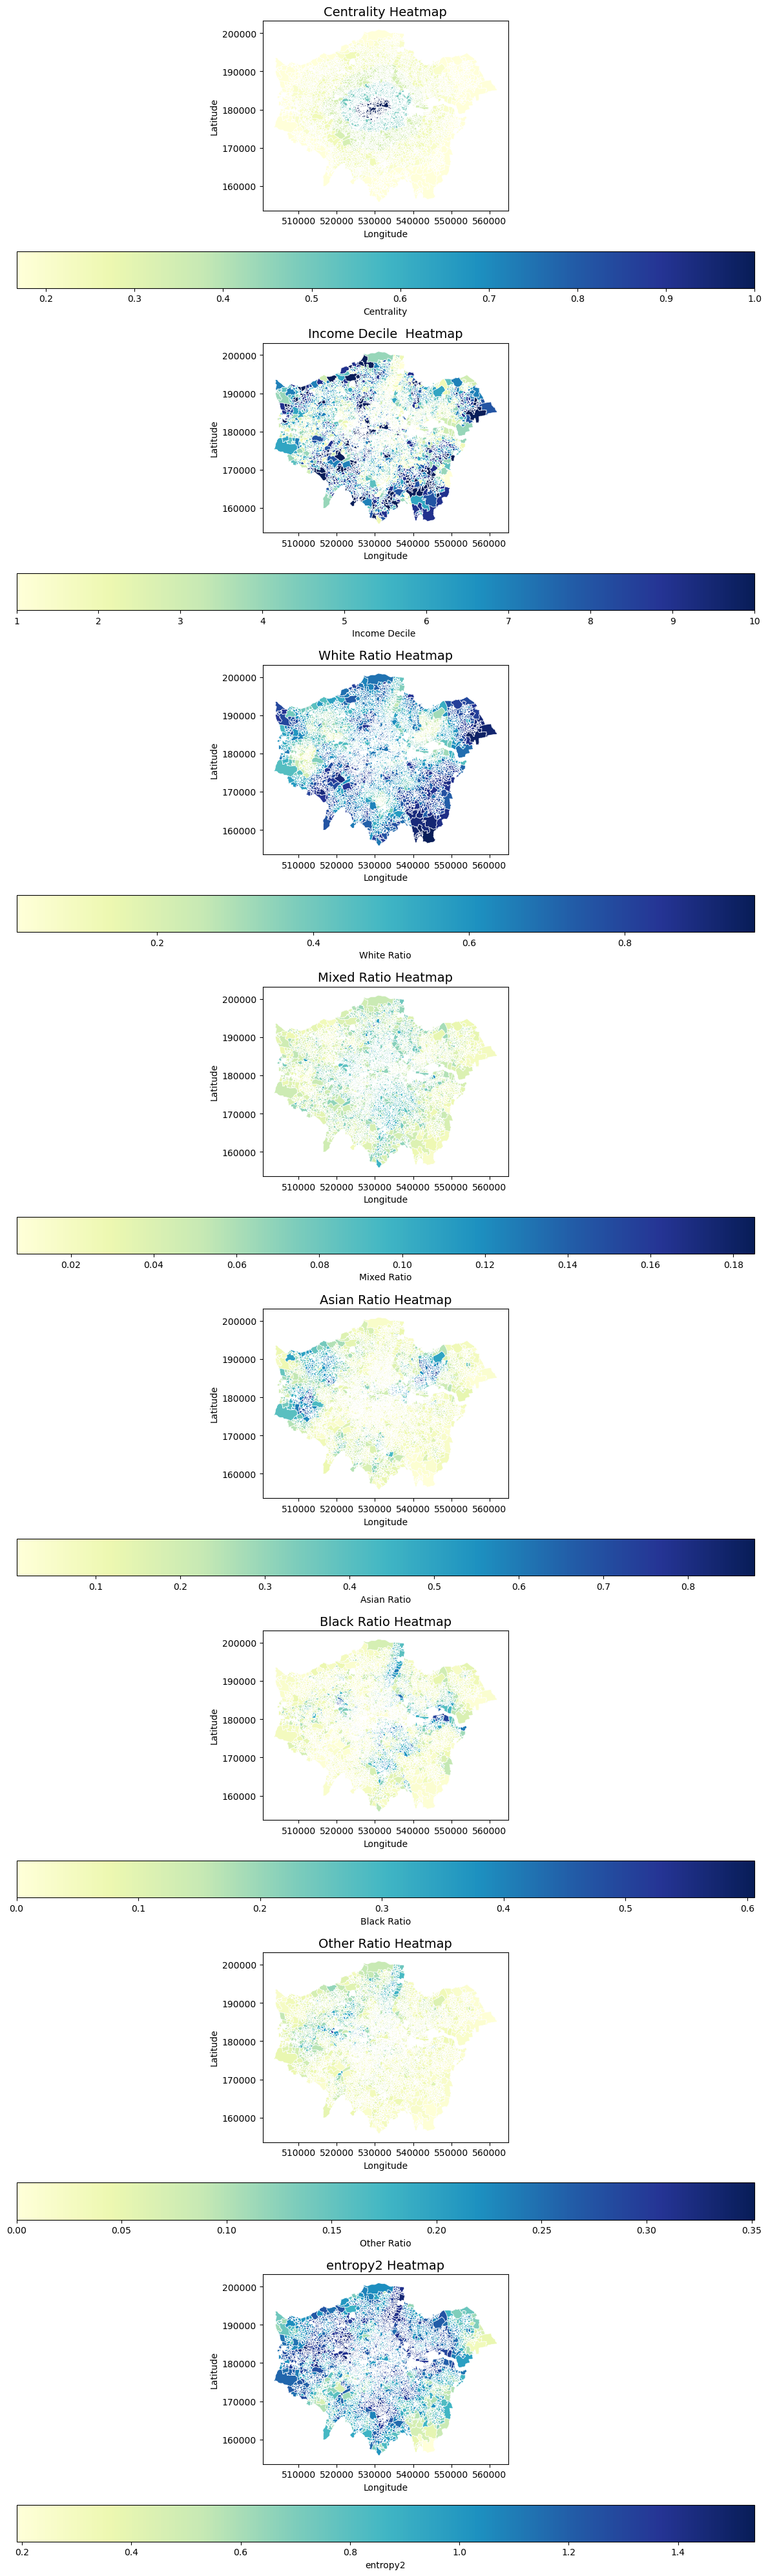

In [15]:
# 列出需要绘制的列名称
columns = ['Centrality', 'Income Decile ', 'White Ratio', 'Mixed Ratio', 
           'Asian Ratio', 'Black Ratio', 'Other Ratio', 'entropy2']

# 设置画布大小
fig, axes = plt.subplots(nrows=len(columns), figsize=(12, len(columns) * 5))

# 遍历每一个列，并依次绘制热力图
for i, column in enumerate(columns):
    ax = axes[i]  # 选择对应的子图
    lsoa_gdf.plot(column=column, ax=ax, legend=True, 
                  cmap='YlGnBu', edgecolor='white', linewidth=0.5, alpha=1,
                  legend_kwds={'label': column, 'orientation': "horizontal"})
    
    # 设置标题和轴标签
    ax.set_title(f'{column} Heatmap', fontsize=14)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

# 调整子图间距以防止重叠
plt.tight_layout()

# 显示图形
plt.show()


1.5 Setting Up Interaction Items

In [16]:
# First check for the presence of these columns
required_columns = ['White Ratio', 'Mixed Ratio', 'Asian Ratio', 'Black Ratio', 'Other Ratio', 'Centrality', 'Income Decile ']
for col in required_columns:
    if col not in lsoa_gdf.columns:
        raise ValueError(f"Column {col} is missing from lsoa_gdf")

# Creating Interaction Columns
lsoa_gdf['White_Rati_Centrality'] = lsoa_gdf['White Ratio'] * lsoa_gdf['Centrality']
lsoa_gdf['Mixed_Rati_Centrality'] = lsoa_gdf['Mixed Ratio'] * lsoa_gdf['Centrality']
lsoa_gdf['Asian_Rati_Centrality'] = lsoa_gdf['Asian Ratio'] * lsoa_gdf['Centrality']
lsoa_gdf['Black_Rati_Centrality'] = lsoa_gdf['Black Ratio'] * lsoa_gdf['Centrality']
lsoa_gdf['Other_Rati_Centrality'] = lsoa_gdf['Other Ratio'] * lsoa_gdf['Centrality']

lsoa_gdf['White_Rati_Income_Decile'] = lsoa_gdf['White Ratio'] * lsoa_gdf['Income Decile ']
lsoa_gdf['Mixed_Rati_Income_Decile'] = lsoa_gdf['Mixed Ratio'] * lsoa_gdf['Income Decile ']
lsoa_gdf['Asian_Rati_Income_Decile'] = lsoa_gdf['Asian Ratio'] * lsoa_gdf['Income Decile ']
lsoa_gdf['Black_Rati_Income_Decile'] = lsoa_gdf['Black Ratio'] * lsoa_gdf['Income Decile ']
lsoa_gdf['Other_Rati_Income_Decile'] = lsoa_gdf['Other Ratio'] * lsoa_gdf['Income Decile ']
# Check the first few rows of the data frame
print(lsoa_gdf.head())

# Check the name of the new column
print(lsoa_gdf.columns)


    LSOA11CD                   LSOA11NM   MSOA11CD                  MSOA11NM  \
0  E01000001        City of London 001A  E02000001        City of London 001   
1  E01000002        City of London 001B  E02000001        City of London 001   
2  E01000003        City of London 001C  E02000001        City of London 001   
3  E01000005        City of London 001E  E02000001        City of London 001   
4  E01000006  Barking and Dagenham 016A  E02000017  Barking and Dagenham 016   

     LAD11CD               LAD11NM    RGN11CD RGN11NM  USUALRES  HHOLDRES  \
0  E09000001        City of London  E12000007  London      1465      1465   
1  E09000001        City of London  E12000007  London      1436      1436   
2  E09000001        City of London  E12000007  London      1346      1250   
3  E09000001        City of London  E12000007  London       985       985   
4  E09000002  Barking and Dagenham  E12000007  London      1703      1699   

   ...  White_Rati_Centrality  Mixed_Rati_Centrality  As

2. Dependent variable Greenspace

2.1Classification of green space according to function and area

In [19]:
# 读取 London wide greenfield entrance 数据
green_space_access_london_gdf = gpd.read_file('Green_Space_Access_London.shp')

# 读取 London wide greenfield 数据
green_space_london_gdf = gpd.read_file('Green_Space_London.shp')

# 查看数据内容
print(green_space_access_london_gdf.head())
print(green_space_london_gdf.head())

                                     id  accessType  \
0  3FAB5BE6-E8B1-4B40-8269-AC4E4A1920A1  Pedestrian   
1  5DF699AE-E6AF-4EC0-9F3C-662ECFBCF41D  Pedestrian   
2  FE4DE1BC-DE01-46C3-A1F6-07EAFFAA2B3C  Pedestrian   
3  662FAA34-C732-43EB-BDA9-A185FFF71A9B  Pedestrian   
4  6E9A56C9-A890-43F4-A075-DA4D7F898376  Pedestrian   

                             refToGSite                               geometry  
0  10687F6C-7D79-64A4-E063-AAEFA00A3B27  POINT Z (536029.100 199680.140 0.000)  
1  10687F6C-7D79-64A4-E063-AAEFA00A3B27  POINT Z (536032.530 199703.920 0.000)  
2  106880E1-1A15-64A4-E063-AAEFA00A3B27  POINT Z (536032.580 199979.480 0.000)  
3  106880E1-1A15-64A4-E063-AAEFA00A3B27  POINT Z (536038.790 200021.020 0.000)  
4  10687F6C-7D79-64A4-E063-AAEFA00A3B27  POINT Z (536047.680 199661.330 0.000)  
                                     id           function  \
0  10687FB1-E1F2-64A4-E063-AAEFA00A3B27  Religious Grounds   
1  10687FB1-E112-64A4-E063-AAEFA00A3B27      Playing Field 

In [22]:
# See the different categories and number of 'function' columns in green_space_london_gdf
function_counts = green_space_london_gdf['function'].value_counts()
print(function_counts)


function
Play Space                                3103
Other Sports Facility                     1514
Public Park Or Garden                     1236
Tennis Court                              1002
Religious Grounds                          755
Allotments Or Community Growing Spaces     751
Playing Field                              724
Bowling Green                              285
Cemetery                                   208
Golf Course                                128
Name: count, dtype: int64


In [23]:
# Ensure that the GeoDataFrame's coordinate reference system is a suitable projected coordinate system for calculating the area
if green_space_london_gdf.crs.is_geographic:
    # Conversion of CRS from a geographic coordinate system (degrees) to a projected coordinate system (meters) suitable for area calculations
    green_space_london_gdf = green_space_london_gdf.to_crs(epsg=27700)

# Calculate the area of each green space (square meters)
green_space_london_gdf['area'] = green_space_london_gdf['geometry'].area

# Group according to the function column and calculate the average area of each category
average_area_by_function = green_space_london_gdf.groupby('function')['area'].mean()

# Print results
print(average_area_by_function)

function
Allotments Or Community Growing Spaces     12678.015286
Bowling Green                               3110.714956
Cemetery                                   59856.114653
Golf Course                               402608.328827
Other Sports Facility                      17195.084317
Play Space                                   865.386350
Playing Field                              44270.156719
Public Park Or Garden                     103597.096622
Religious Grounds                           3718.062192
Tennis Court                                1801.315316
Name: area, dtype: float64


/tmp/ipykernel_127/1375869242.py:38: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(title='Green Space Levels')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


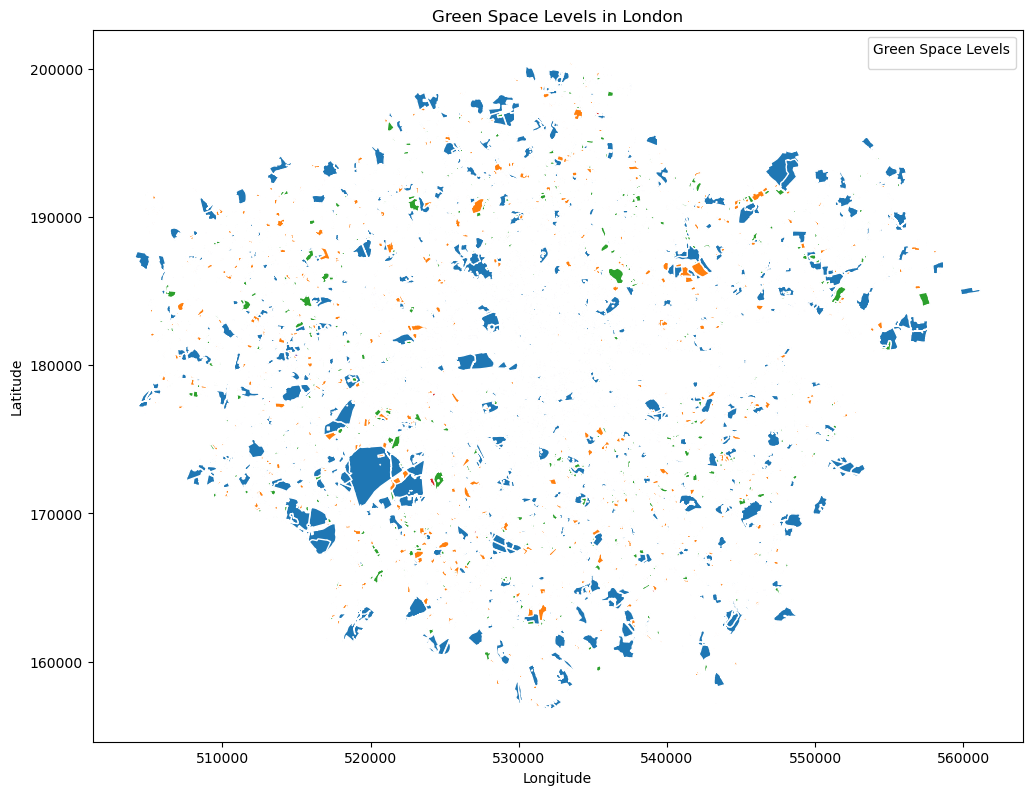

In [24]:
# Define the green space grade and corresponding color
# Assume that the grade information is in the 'function' column and that colors have been assigned by grade
# The following grade and color definitions can be adjusted to match the actual data
level_colors = {
    'Very Large Green Spaces': '#1f77b4',   
    'Large Green Spaces': '#ff7f0e',        
    'Medium Green Spaces': '#2ca02c',       
    'Small Green Spaces': '#d62728',       
    'Very Small Green Spaces': '#9467bd'    
}

# Adding level information to the data box
def map_to_level(function):
    if function in ['Golf Course', 'Public Park Or Garden']:
        return 'Very Large Green Spaces'
    elif function in ['Cemetery', 'Playing Field']:
        return 'Large Green Spaces'
    elif function in ['Allotments Or Community Growing Spaces', 'Other Sports Facility']:
        return 'Medium Green Spaces'
    elif function in ['Religious Grounds', 'Bowling Green', 'Tennis Court']:
        return 'Small Green Spaces'
    elif function == 'Play Space':
        return 'Very Small Green Spaces'
    else:
        return 'Unknown'

green_space_london_gdf['level'] = green_space_london_gdf['function'].apply(map_to_level)

# Creating a drawing
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Mapping each class of green space
for level, color in level_colors.items():
    subset = green_space_london_gdf[green_space_london_gdf['level'] == level]
    subset.plot(ax=ax, color=color, label=level, edgecolor='white')

# Setting the legend and title
plt.legend(title='Green Space Levels')
plt.title('Green Space Levels in London')
plt.xlabel('Longitude')
plt.ylabel('Latitude')


plt.show()


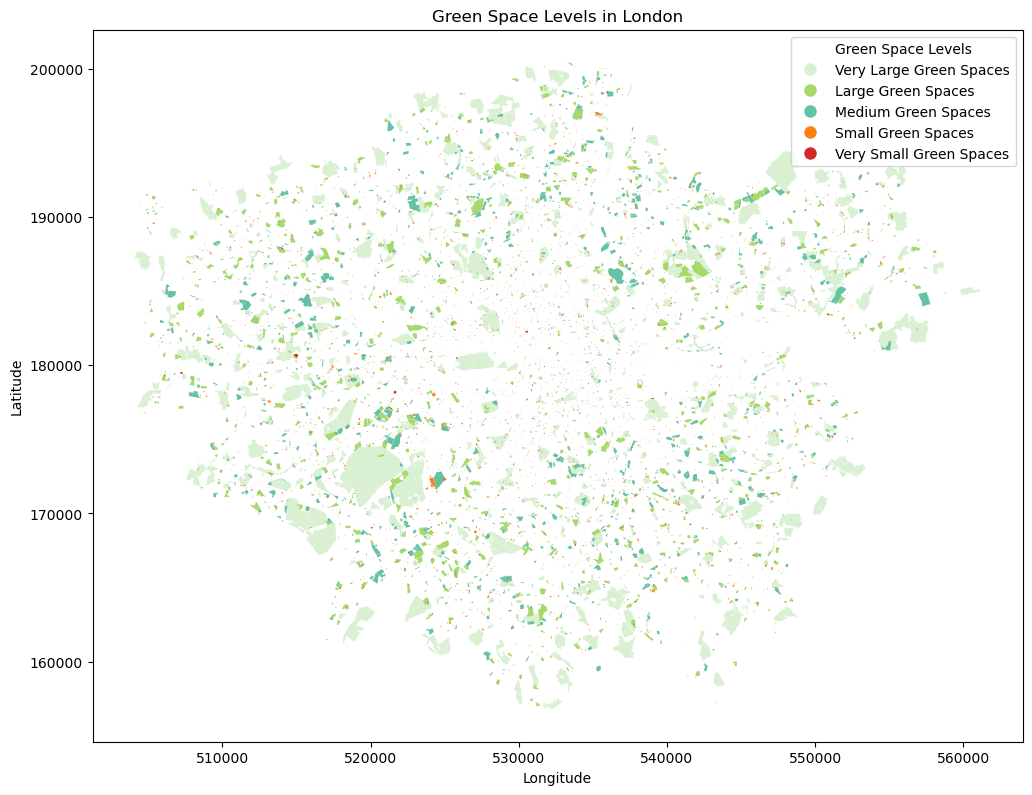

In [25]:

level_colors = {
    'Very Large Green Spaces': '#d9f0d3',  
    'Large Green Spaces': '#a6d96a',        
    'Medium Green Spaces': '#66c2a5',       
    'Small Green Spaces': '#ff7f0e',        
    'Very Small Green Spaces': '#d62728',   
}

def map_to_level(function):
    if function in ['Golf Course', 'Public Park Or Garden']:
        return 'Very Large Green Spaces'
    elif function in ['Cemetery', 'Playing Field']:
        return 'Large Green Spaces'
    elif function in ['Allotments Or Community Growing Spaces', 'Other Sports Facility']:
        return 'Medium Green Spaces'
    elif function in ['Religious Grounds', 'Bowling Green', 'Tennis Court']:
        return 'Small Green Spaces'
    elif function == 'Play Space':
        return 'Very Small Green Spaces'
    else:
        return 'Unknown'

green_space_london_gdf['level'] = green_space_london_gdf['function'].apply(map_to_level)

fig, ax = plt.subplots(1, 1, figsize=(12, 10))

for level, color in level_colors.items():
    subset = green_space_london_gdf[green_space_london_gdf['level'] == level]
    subset.plot(ax=ax, color=color, label=level)


legend_elements = [Line2D([0], [0], marker='o', color='w', label=level,
                         markersize=10, markerfacecolor=color) for level, color in level_colors.items()]


ax.legend(handles=legend_elements, title='Green Space Levels', loc='best')
ax.set_title('Green Space Levels in London')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()


In [26]:
# Spatial connectivity, merging greenfield data with regional data
joined_gdf = gpd.sjoin(green_space_london_gdf, lsoa_gdf, how="inner", op="intersects")
print(green_space_london_gdf.columns)
print(joined_gdf.columns)

/opt/conda/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/tmp/ipykernel_127/2221017713.py:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:27700
Right CRS: PROJCS["OSGB36 / British National Grid",GEOGCS["OS ...

  joined_gdf = gpd.sjoin(green_space_london_gdf, lsoa_gdf, how="inner", op="intersects")


Index(['id', 'function', 'distName1', 'distName2', 'distName3', 'distName4',
       'geometry', 'area', 'level'],
      dtype='object')
Index(['id', 'function', 'distName1', 'distName2', 'distName3', 'distName4',
       'geometry', 'area', 'level', 'index_right', 'LSOA11CD', 'LSOA11NM',
       'MSOA11CD', 'MSOA11NM', 'LAD11CD', 'LAD11NM', 'RGN11CD', 'RGN11NM',
       'USUALRES', 'HHOLDRES', 'COMESTRES', 'POPDEN', 'HHOLDS', 'AVHHOLDSZ',
       'LSOA code', 'local authority name', 'local authority code',
       'All usual residents', 'White British', 'White Irish',
       'White Gypsy/Irish Traveller', 'White Roma', 'White Other',
       'Mixed White and Asian', 'Mixed White and Black African',
       'Mixed White and Black Caribbean', 'Mixed Other', 'Asian Bangladeshi',
       'Asian Chinese', 'Asian Indian', 'Asian Pakistani', 'Asian Other',
       'Black African', 'Black Caribbean', 'Black Other', 'Other Arab',
       'Other Any other', 'White', 'Mixed', 'Asian', 'Black', 'Other',
   

In [27]:
# Calculate the area of each green space (assuming units of square meters)
green_space_london_gdf['area'] = green_space_london_gdf.geometry.area
print(green_space_london_gdf[['function', 'area']].head())


            function         area
0  Religious Grounds   1167.83000
1      Playing Field  17514.96610
2  Religious Grounds   4118.67500
3         Play Space    268.62255
4         Play Space    439.64245


In [28]:
# Calculate the total area of each class in each region
area_summary = joined_gdf.groupby(['LSOA11CD', 'level'])['area'].sum().reset_index()

# Using a pivot table, convert the green space area for each class into columns
pivot_table = area_summary.pivot(index='LSOA11CD', columns='level', values='area').fillna(0)

# Displaying a portion of a pivot table
print(pivot_table.head())

level      Large Green Spaces  Medium Green Spaces  Small Green Spaces  \
LSOA11CD                                                                 
E01000001           706.12525              0.00000                 0.0   
E01000002           348.57890              0.00000                 0.0   
E01000003             0.00000           5275.73975                 0.0   
E01000005             0.00000              0.00000                 0.0   
E01000007          1671.43700            186.93220                 0.0   

level      Very Large Green Spaces  Very Small Green Spaces  
LSOA11CD                                                     
E01000001               2597.70225                  0.00000  
E01000002               2710.96315                  0.00000  
E01000003                  0.00000                  0.00000  
E01000005               2386.27790                557.48580  
E01000007                  0.00000               1967.29525  


In [29]:
# Calculate the number of green spaces per LSOA area and per green space class
lsoa_level_counts = joined_gdf.groupby(['LSOA11CD', 'level']).size().reset_index(name='count')

#  Use a pivot table to convert the number of green spaces in each green space class into columns
pivot_table = lsoa_level_counts.pivot(index='LSOA11CD', columns='level', values='count').fillna(0)

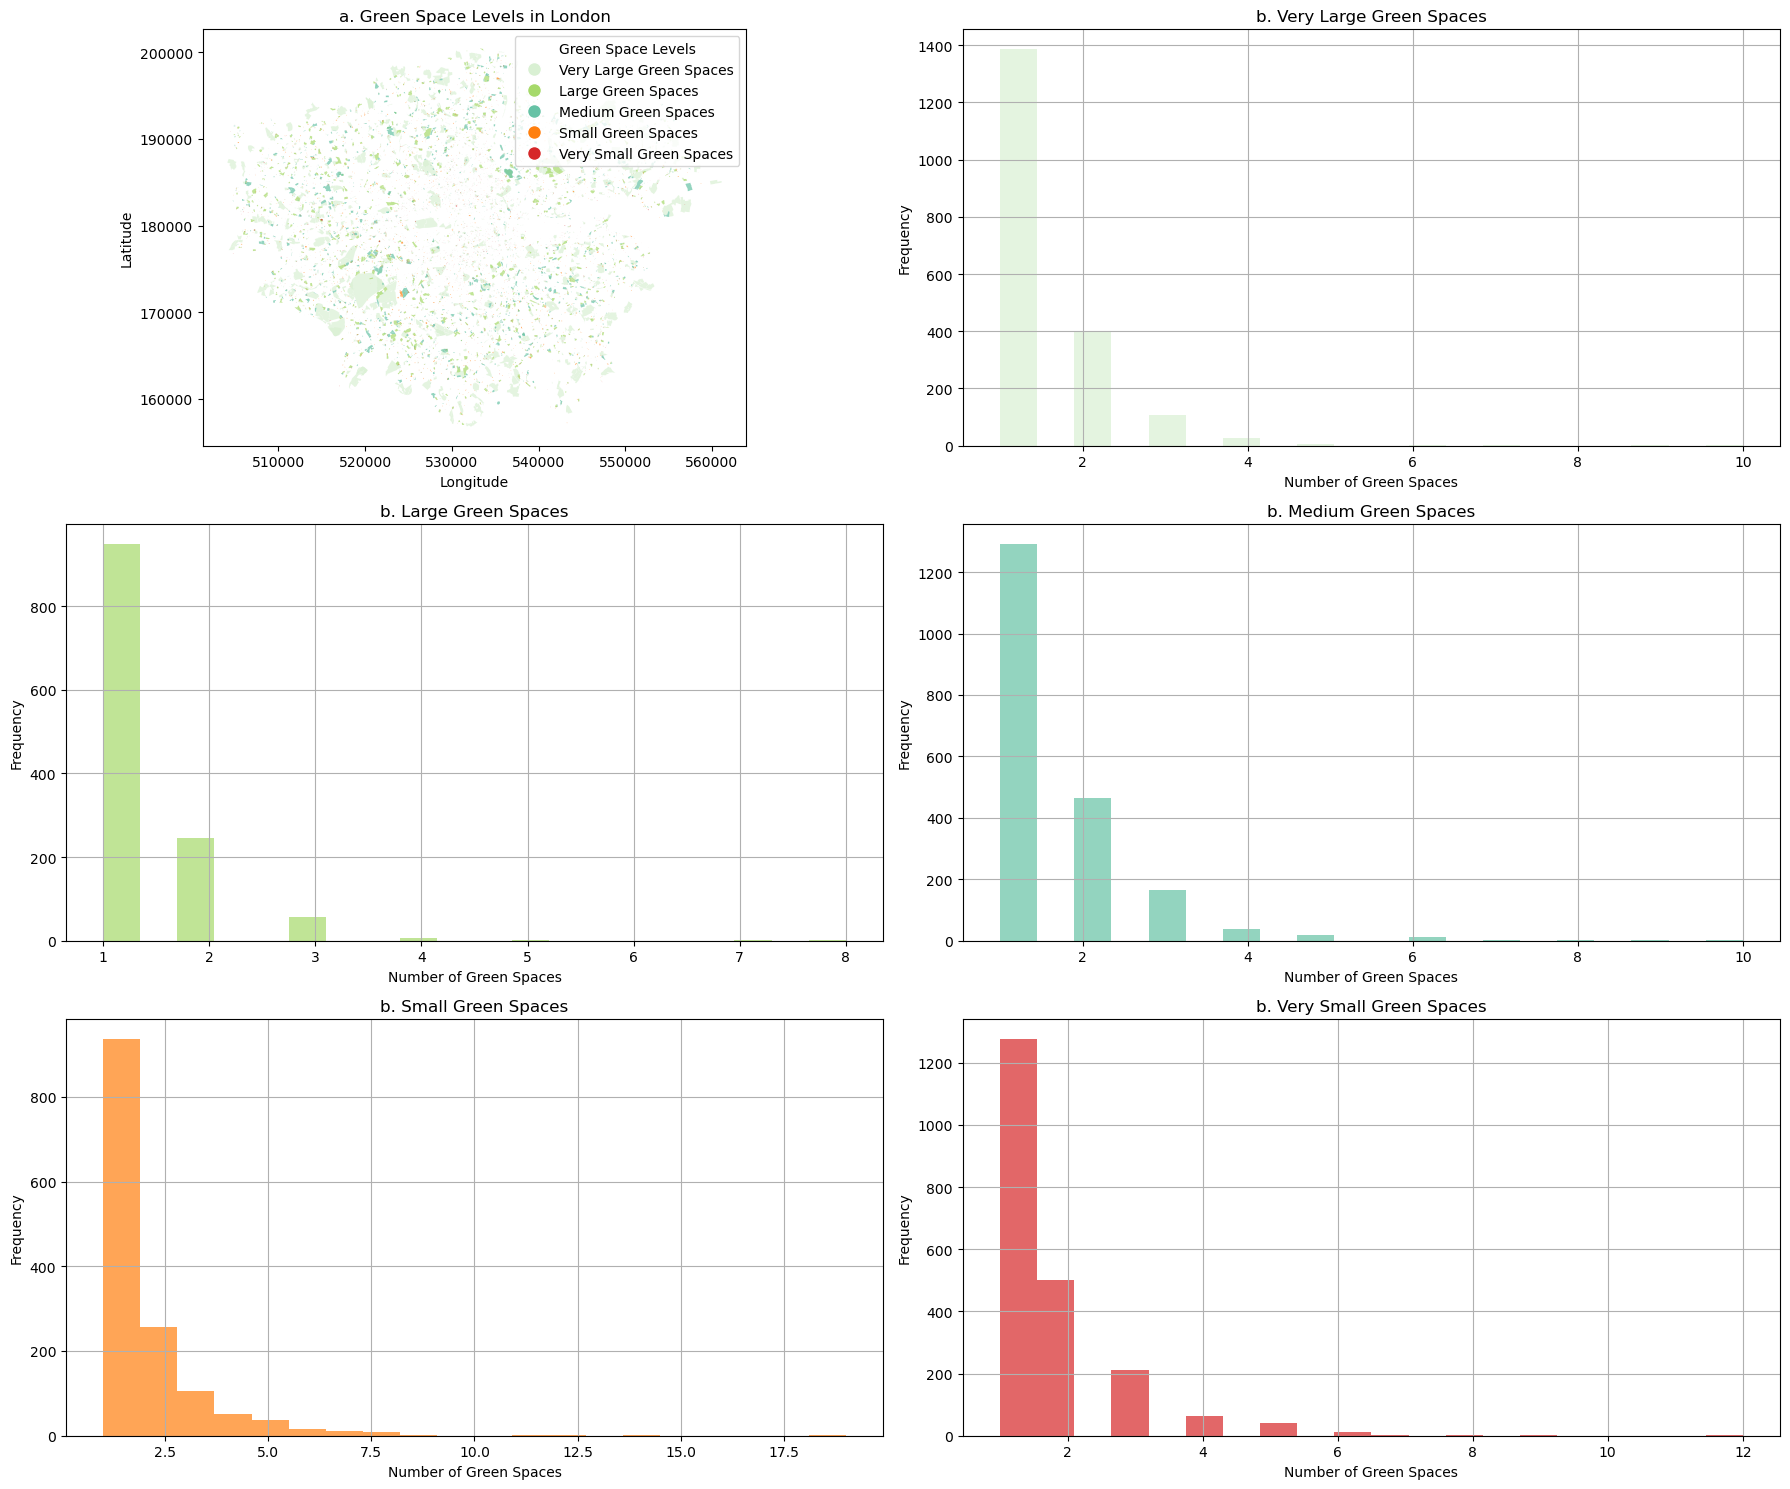

In [30]:
# Assuming green_space_london_gdf is defined and contains the 'function' column
# Define green space classes and corresponding colors
level_colors = {
    'Very Large Green Spaces': '#d9f0d3',  
    'Large Green Spaces': '#a6d96a',       
    'Medium Green Spaces': '#66c2a5',      
    'Small Green Spaces': '#ff7f0e',      
    'Very Small Green Spaces': '#d62728', 
}

# Add class information to the data box, assuming the 'function' column contains the actual green space class
def map_to_level(function):
    if function in ['Golf Course', 'Public Park Or Garden']:
        return 'Very Large Green Spaces'
    elif function in ['Cemetery', 'Playing Field']:
        return 'Large Green Spaces'
    elif function in ['Allotments Or Community Growing Spaces', 'Other Sports Facility']:
        return 'Medium Green Spaces'
    elif function in ['Religious Grounds', 'Bowling Green', 'Tennis Court']:
        return 'Small Green Spaces'
    elif function == 'Play Space':
        return 'Very Small Green Spaces'
    else:
        return 'Unknown'

# Create drawings
fig, axes = plt.subplots(3, 2, figsize=(18, 15))
axes = axes.flatten()

# Subfigure a: Showing the various classes of green spaces
for level, color in level_colors.items():
    subset = green_space_london_gdf[green_space_london_gdf['level'] == level]
    subset.plot(ax=axes[0], color=color, label=level, markersize=10, alpha=0.7)

# Customized legend marking symbols
legend_elements = [Line2D([0], [0], marker='o', color='w', label=level,
                         markersize=10, markerfacecolor=color) for level, color in level_colors.items()]

# Add legend and title
axes[0].legend(handles=legend_elements, title='Green Space Levels', loc='best')
axes[0].set_title('a. Green Space Levels in London')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')

# Sub-figure b: Histogram showing the number of different classes of green space
for i, (level, color) in enumerate(level_colors.items()):
    subset = lsoa_level_counts[lsoa_level_counts['level'] == level]
    axes[i+1].hist(subset['count'], bins=20, alpha=0.7, color=color)
    axes[i+1].set_title(f'b. {level}')
    axes[i+1].set_xlabel('Number of Green Spaces')
    axes[i+1].set_ylabel('Frequency')
    axes[i+1].grid(True)

# Restructuring of the layout
plt.tight_layout()

# Display Graphics
plt.show()


In [31]:
# Read Shapefile
access_point_gdf = gpd.read_file('access point new.shp')
# Define green space classes and corresponding colors
level_colors = {
    'Very Large Green Spaces': '#d9f0d3', 
    'Large Green Spaces': '#a6d96a',        
    'Medium Green Spaces': '#66c2a5',       
    'Small Green Spaces': '#ff7f0e',       
    'Very Small Green Spaces': '#d62728',  
}

# Classification according to function column
def map_to_level(function):
    if function in ['Golf Course', 'Public Park Or Garden']:
        return 'Very Large Green Spaces'
    elif function in ['Cemetery', 'Playing Field']:
        return 'Large Green Spaces'
    elif function in ['Allotments Or Community Growing Spaces', 'Other Sports Facility']:
        return 'Medium Green Spaces'
    elif function in ['Religious Grounds', 'Bowling Green', 'Tennis Court']:
        return 'Small Green Spaces'
    elif function == 'Play Space':
        return 'Very Small Green Spaces'
    else:
        return 'Unknown'

# Add hierarchical columns
access_point_gdf['level'] = access_point_gdf['function'].apply(map_to_level)


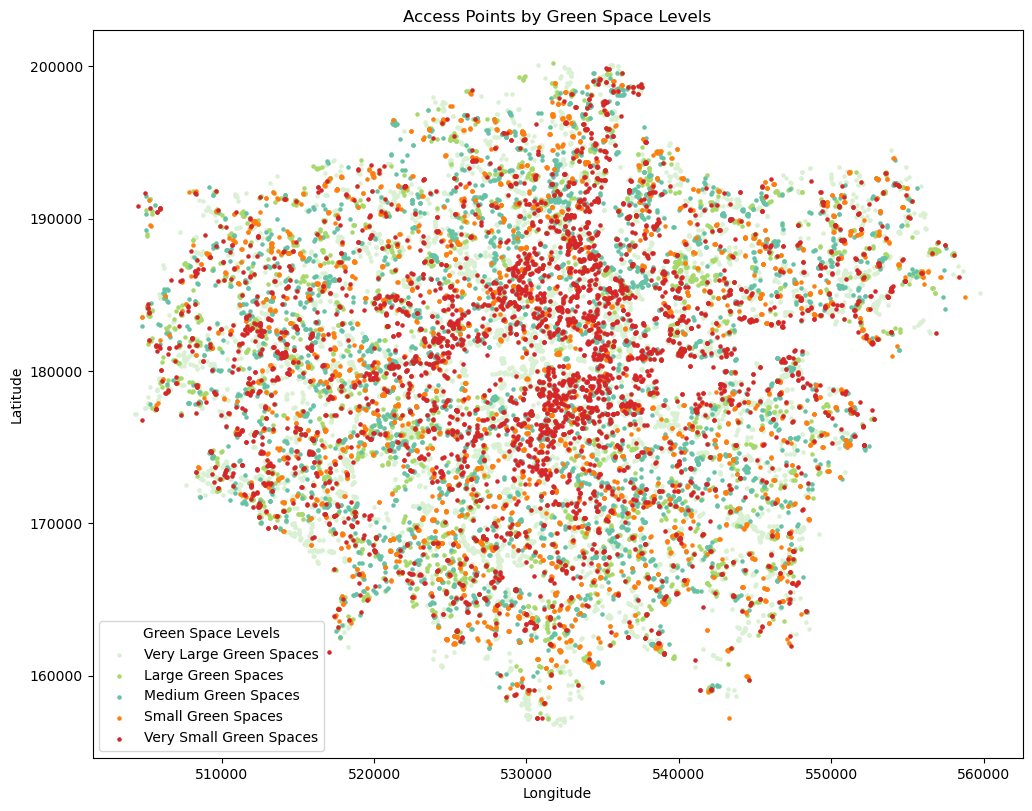

In [33]:
# 创建绘图
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# 绘制每种等级的点
for level, color in level_colors.items():
    subset = access_point_gdf[access_point_gdf['level'] == level]
    subset.plot(ax=ax, color=color, marker='o', label=level, markersize=5)

# 添加图例和标题
ax.legend(title='Green Space Levels', loc='best')
ax.set_title('Access Points by Green Space Levels')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# 显示图形
plt.show()


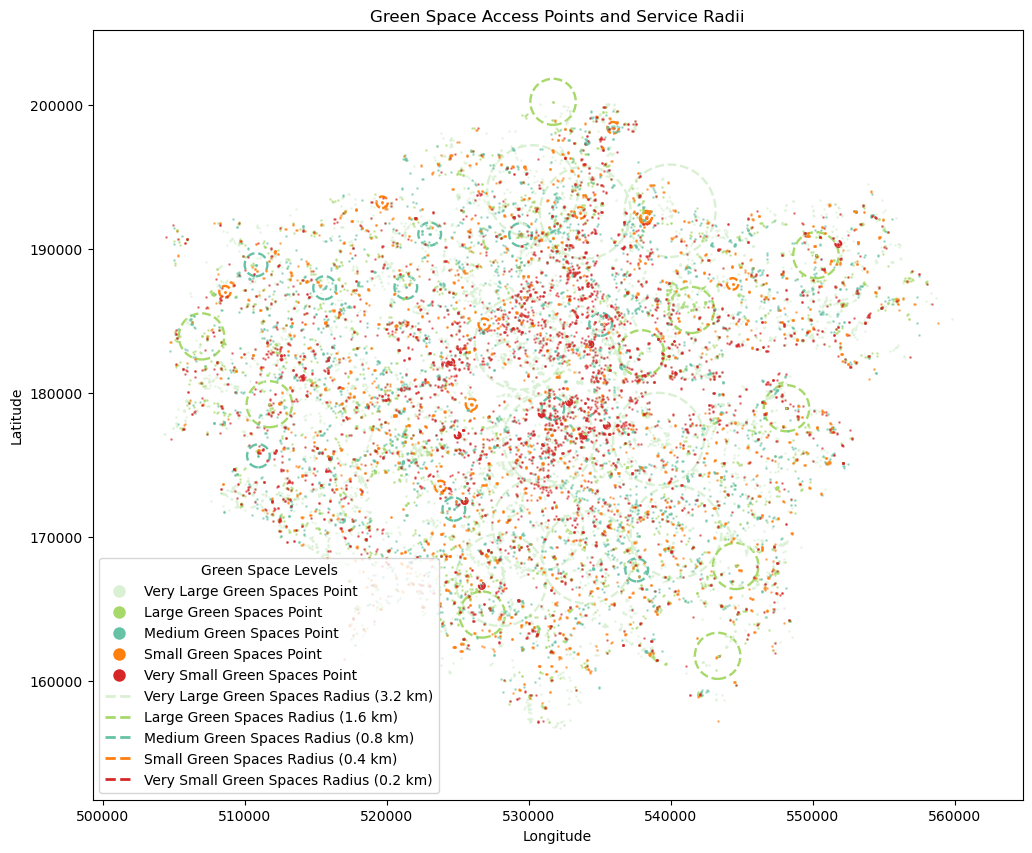

In [35]:
from matplotlib.patches import Circle
# Define green space classes and corresponding colors and radii
level_colors = {
    'Very Large Green Spaces': '#d9f0d3',   
    'Large Green Spaces': '#a6d96a',        
    'Medium Green Spaces': '#66c2a5',       
    'Small Green Spaces': '#ff7f0e',        
    'Very Small Green Spaces': '#d62728',   
}

service_radii = {
    'Very Large Green Spaces': 3200,  # 3.2 km
    'Large Green Spaces': 1600,       # 1.6 km
    'Medium Green Spaces': 800,        # 800 m
    'Small Green Spaces': 400,         # 400 m
    'Very Small Green Spaces': 200,      # No specific radius
}


# Select 10 points for each level
sample_points = access_point_gdf.groupby('level').apply(lambda x: x.sample(n=min(10, len(x)))).reset_index(drop=True)

# Creating a drawing
fig, ax = plt.subplots(figsize=(12, 10))

# Mapping points and their service radius for each class
for level, color in level_colors.items():
    subset = sample_points[sample_points['level'] == level]
    for _, row in subset.iterrows():
        # plotting point
        ax.plot(row.geometry.x, row.geometry.y, 'o', color=color, markersize=0.8, label=f'{level} Point')
        # Mapping the service radius
        radius = service_radii[level]
        if radius > 0:  # Points without a specific service radius are not plotted
            circle = Circle((row.geometry.x, row.geometry.y), radius, color=color, fill=False, linestyle='--', linewidth=1.7)
            ax.add_patch(circle)

# Plot all points of each class (for legend)
for level, color in level_colors.items():
    subset = access_point_gdf[access_point_gdf['level'] == level]
    ax.scatter(subset.geometry.x, subset.geometry.y, color=color, label=level, alpha=0.5, s=0.8)  # 设置点的大小为 10

# Creating Legend Elements
point_legend = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=f'{level} Point') for level, color in level_colors.items()]

# Legend for creating a service radius
radius_legend = []
for level, radius in service_radii.items():
    if radius > 0:  # Create legends only for classes with specific radii
        # Use a smaller radius (relative to the actual data) and display the service radius with a circle filled with transparency
        legend_circle = Circle((0, 0), radius / 1000, color=level_colors[level], fill=False, linestyle='--', linewidth=2)
        radius_legend.append(Line2D([0], [0], color=level_colors[level], linestyle='--', linewidth=2, label=f'{level} Radius ({radius / 1000} km)'))

# Add legend and title
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=point_legend + radius_legend, title='Green Space Levels', loc='best')

ax.set_title('Green Space Access Points and Service Radii')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Setting the range of axes (adjusted to actual data)
ax.set_xlim(access_point_gdf.geometry.x.min() - 5000, access_point_gdf.geometry.x.max() + 5000)
ax.set_ylim(access_point_gdf.geometry.y.min() - 5000, access_point_gdf.geometry.y.max() + 5000)

# Display Graphics
plt.show()

3.Calculating green space accessibility with QGIS

In [36]:
# Read green space accessibility.csv File
lsoa_sum_df = pd.read_csv('lsoa sum.csv')
# Extract the required columns
lsoa_sum_df = lsoa_sum_df[['LSOA11CD', 'ai', 'ai2']]

# View extracted data
print("Extracted data:")
print(lsoa_sum_df.head())

Extracted data:
    LSOA11CD           ai        ai2
0  E01000001  52612.68338  11.424604
1  E01000002  54450.55146  11.974561
2  E01000003  46513.16574  10.211846
3  E01000005  56438.26604  12.497042
4  E01000006  18501.89314   4.228493


In [37]:
# Merge lsoa_sum_df to lsoa_gdf
lsoa_gdf = lsoa_gdf.merge(lsoa_sum_df, left_on='LSOA11CD', right_on='LSOA11CD', how='left')

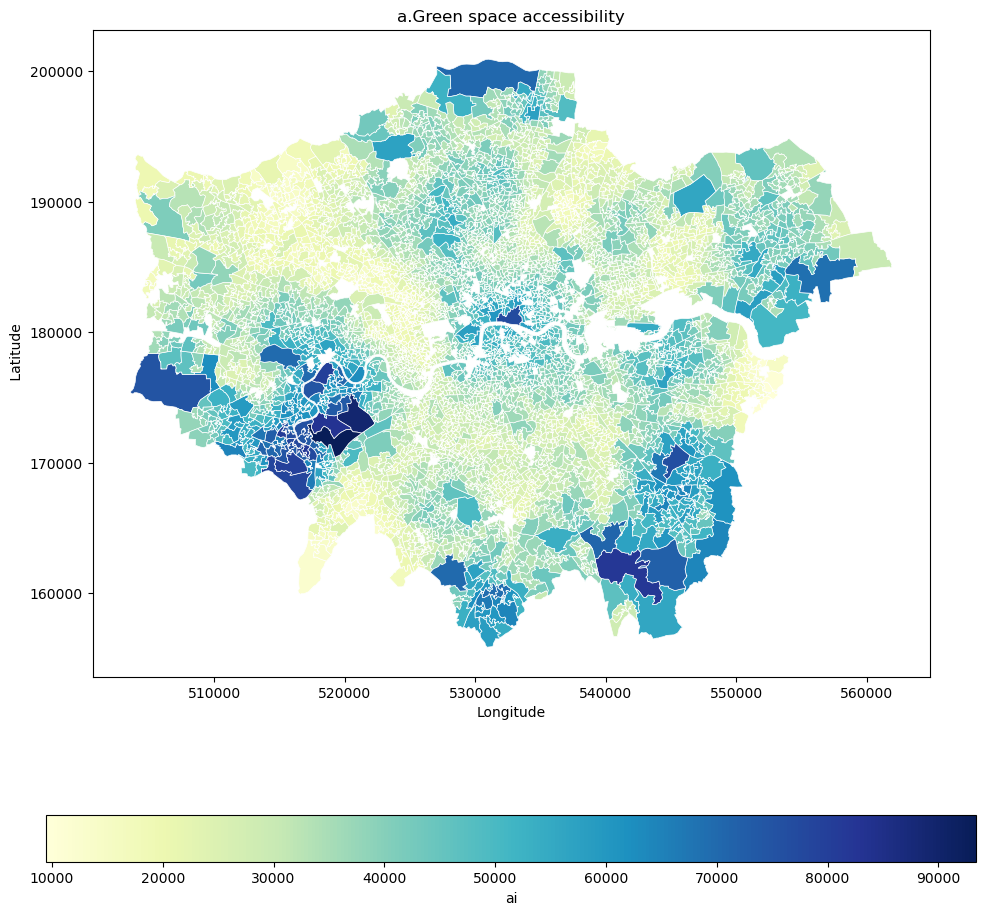

In [38]:
# Drawing heat maps for filled shapes
fig, ax = plt.subplots(figsize=(12, 12))
# Mapping LSOA Boundaries and Heat Maps
lsoa_gdf.plot(column='ai', ax=ax, legend=True,
              cmap='YlGnBu', edgecolor='white',linewidth=0.5, alpha=1,
              legend_kwds={'label': "ai",
                           'orientation': "horizontal"})

# Setting up titles and labels
plt.title('a.Green space accessibility')
plt.xlabel('Longitude')
plt.ylabel(' Latitude')

# Display Graphics
plt.show()

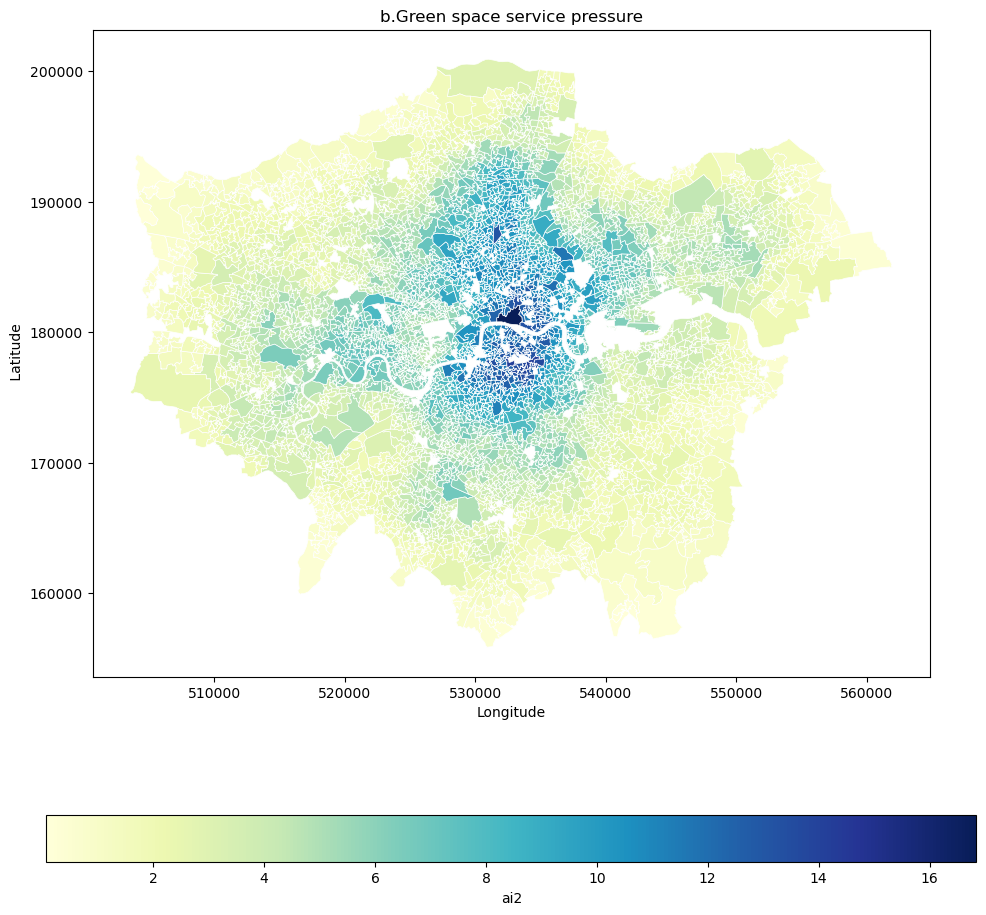

In [40]:
# Drawing heat maps for filled shapes
fig, ax = plt.subplots(figsize=(12, 12))
# Mapping LSOA Boundaries and Heat Maps
lsoa_gdf.plot(column='ai2', ax=ax, legend=True,
              cmap='YlGnBu', edgecolor='white',linewidth=0.5, alpha=1,
              legend_kwds={'label': "ai2",
                           'orientation': "horizontal"})

# Setting up titles and labels
plt.title('b.Green space service pressure')
plt.xlabel('Longitude')
plt.ylabel(' Latitude')

# Display Graphics
plt.show()

3.OLS,RR,GWR regression

In [43]:
import geopandas as gpd
from libpysal.weights import Kernel
from pysal.model import spreg
from mgwr.gwr import GWR
!pip install stargazer
# Load libraries
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from pylab import rcParams
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 72

import seaborn as sns
sns.set_style("darkgrid")
sns.set_context(context="paper", font_scale=1.5, rc=None)
sns.set(font="serif")

import plotly.express as px
import plotly.graph_objects as go

import geopandas as gpd


import libpysal as ps
from libpysal  import weights
from libpysal.weights import Queen

import esda
from esda.moran import Moran, Moran_Local

import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster, plot_local_autocorrelation
from splot.libpysal import plot_spatial_weights

from giddy.directional import Rose

import statsmodels.api as sm
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer, LineLocation

from spreg import OLS
from spreg import MoranRes
from spreg import ML_Lag
from spreg import ML_Error 

from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.utils import shift_colormap, truncate_colormap

import warnings
warnings.filterwarnings('ignore') 
import time
from stargazer.stargazer import Stargazer
!pip install --upgrade statsmodels
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


/opt/conda/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:38: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/opt/conda/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:164: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/opt/conda/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:198: NumbaDeprecationWarning: The 'nopython' keyw

  Obtaining dependency information for stargazer from https://files.pythonhosted.org/packages/af/49/0f0bc34f94e6ba65f8e5cc06208d11759153f02fb61f4a9f9db98e86bb68/stargazer-0.0.7-py3-none-any.whl.metadata


/opt/conda/lib/python3.11/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/opt/conda/lib/python3.11/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/opt/conda/lib/python3.11/site-packages/quantecon/lss.py:19: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59

  Obtaining dependency information for statsmodels from https://files.pythonhosted.org/packages/7f/0a/28b3b3c807a518b7d0ed0ae45bfdd6be23b38a0c60790f90ce1f8383a640/statsmodels-0.14.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for pandas!=2.1.0,>=1.4 from https://files.pythonhosted.org/packages/fc/a5/4d82be566f069d7a9a702dcdf6f9106df0e0b042e738043c0cc7ddd7e3f6/pandas-2.2.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for patsy>=0.5.6 from https://files.pythonhosted.org/packages/43/f3/1d311a09c34f14f5973bb0bb0dc3a6e007e1eda90b5492d082689936ca51/patsy-0.5.6-py2.py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 2.7 MB/s eta 0:00:0000:010:010m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 1.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.9/233.9 kB 3.0 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pa

In [44]:
import statsmodels
print(statsmodels.__version__)

0.14.0


3.1 correlation

In [55]:
lsoa_gdf = lsoa_gdf.rename(columns={
    'ai': 'Green space accessibility',
    'ai2': 'Green Space Service Pressure',
    'entropy2':'Racial Segregation Index'
})

In [92]:
# Specify the columns to select
columns_of_interest = [
    'Green space accessibility','Green Space Service Pressure','White Ratio', 'Mixed Ratio', 'Asian Ratio', 'Black Ratio','Income Decile ',
       'Other Ratio', 'Centrality','White_Rati_Centrality', 'Mixed_Rati_Centrality', 'Asian_Rati_Centrality', 'Black_Rati_Centrality', 'Other_Rati_Centrality', 'White_Rati_Income_Decile','Mixed_Rati_Income_Decile','Black_Rati_Income_Decile','Asian_Rati_Income_Decile','Other_Rati_Income_Decile','Racial Segregation Index','Centrality'
]

# Select these columns from merged_df
new_df = lsoa_gdf[columns_of_interest]

# View selected columns
print(new_df.head())

   Green space accessibility  Green Space Service Pressure  White Ratio  \
0                52612.68338                     11.424604     0.802444   
1                54450.55146                     11.974561     0.783960   
2                46513.16574                     10.211846     0.741294   
3                56438.26604                     12.497042     0.392210   
4                18501.89314                      4.228493     0.327027   

   Mixed Ratio  Asian Ratio  Black Ratio  Income Decile   Other Ratio  \
0     0.036660     0.107264     0.007468              10     0.046164   
1     0.043353     0.130780     0.006503              10     0.035405   
2     0.062189     0.093905     0.034204               6     0.068408   
3     0.071558     0.315217     0.105978               2     0.115036   
4     0.038919     0.478378     0.108649               5     0.047027   

   Centrality  White_Rati_Centrality  Mixed_Rati_Centrality  \
0        1.00               0.802444           

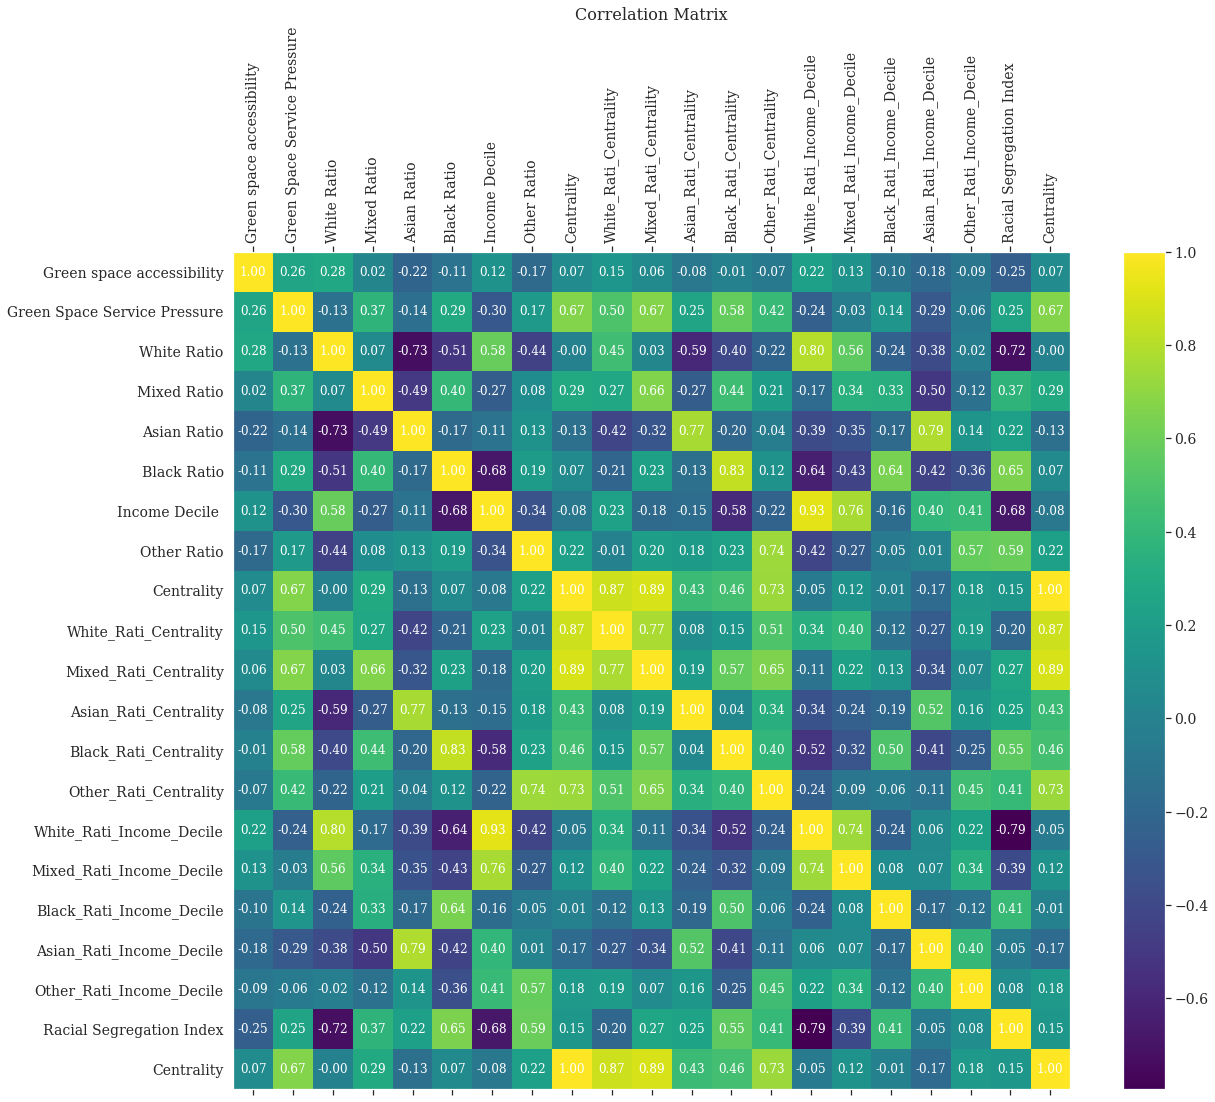

In [93]:
df = new_df
plt.rcParams["axes.grid"] = False
f = plt.figure(figsize=(19, 15))

# Calculate the correlation matrix
corr_matrix = df.corr()

# Draw the correlation matrix, using the blue-green-yellow color scheme
plt.matshow(corr_matrix, fignum=f.number, cmap='viridis')

# Setting the scale labels
plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=90)
plt.yticks(range(df.shape[1]), df.columns, fontsize=14)

# Add a color bar
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)

# Add the value of the correlation coefficient to the matrix
for (i, j), val in np.ndenumerate(corr_matrix):
    plt.text(j, i, f'{val:.2f}', ha='center', va='center', fontsize=12, color='white')

plt.show()


VIF

In [94]:
predictor_columns = [
    'White Ratio', 'Mixed Ratio', 'Asian Ratio', 'Black Ratio','Income Decile ',
       'Other Ratio', 'Centrality']
# Create dataframes containing predictor variables
df = lsoa_gdf[predictor_columns]

In [49]:
# calculating VIF
# This function is adjusted from: https://stackoverflow.com/a/51329496/4667568
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

def drop_column_using_vif_(df, thresh=15):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: (default 5) the threshould VIF value. If the VIF of a variable is greater than thresh, it should be removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data. add_constant is a function from statsmodels (see the import above)
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const
        vif_df = vif_df.drop('const')
      # if the largest VIF is above the thresh, remove a variable with the largest VIF
        # If there are multiple variabels with VIF>thresh, only one of them is removed. This is because we want to keep as many variables as possible
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df

In [50]:
df_new = drop_column_using_vif_(df)

Dropping: White Ratio


3.2 OLS regression

In [95]:
new_df_rental = sm.OLS(endog=lsoa_gdf[['Green space accessibility']], exog=sm.add_constant(df)).fit()
new_df_rental.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     Green space accessibility   R-squared:                       0.096
Model:                                   OLS   Adj. R-squared:                  0.094
Method:                        Least Squares   F-statistic:                     81.99
Date:                       Wed, 28 Aug 2024   Prob (F-statistic):           7.19e-98
Time:                               02:03:11   Log-Likelihood:                -49638.
No. Observations:                       4659   AIC:                         9.929e+04
Df Residuals:                           4652   BIC:                         9.933e+04
Df Model:                                  6                                         
Covariance Type:                   nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1.689e+04   1277.184     13.221      0.000    1.44e+04    1.94e+04
White Ratio     2.678e+04   1940.177     13.805      0.000     2.3e+04    3.06e+04
Mixed Ratio    -1.759e+04   7894.935     -2.228      0.026   -3.31e+04   -2109.888
Asian Ratio     9374.7522   1636.657      5.728      0.000    6166.129    1.26e+04
Black Ratio     1.193e+04   2693.598      4.429      0.000    6648.082    1.72e+04
Income Decile   -294.6362     86.626     -3.401      0.001    -464.465    -124.808
Other Ratio    -1.361e+04   3822.687     -3.561      0.000   -2.11e+04   -6119.355
Centrality      5896.7950    888.065      6.640      0.000    4155.766    7637.824
==============================================================================
Omnibus:                      504.662   Durbin-Watson:                   0.460
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              838.034
Skew:                           0.760   Prob(JB):                    1.05e-182
Kurtosis:                       4.417   Cond. No.                     5.83e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.42e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [96]:
new_df_rental = sm.OLS(endog=lsoa_gdf[['Green Space Service Pressure']], exog=sm.add_constant(df)).fit()
new_df_rental.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                 
========================================================================================
Dep. Variable:     Green Space Service Pressure   R-squared:                       0.529
Model:                                      OLS   Adj. R-squared:                  0.528
Method:                           Least Squares   F-statistic:                     869.1
Date:                          Wed, 28 Aug 2024   Prob (F-statistic):               0.00
Time:                                  02:03:31   Log-Likelihood:                -9980.9
No. Observations:                          4659   AIC:                         1.998e+04
Df Residuals:                              4652   BIC:                         2.002e+04
Df Model:                                     6                                         
Covariance Type:                      nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              3.7853      0.257     14.740      0.000       3.282       4.289
White Ratio       -2.4125      0.390     -6.184      0.000      -3.177      -1.648
Mixed Ratio       13.9289      1.587      8.775      0.000      10.817      17.041
Asian Ratio       -2.3104      0.329     -7.021      0.000      -2.956      -1.665
Black Ratio        0.5374      0.542      0.992      0.321      -0.524       1.599
Income Decile     -0.1900      0.017    -10.907      0.000      -0.224      -0.156
Other Ratio       -5.9582      0.769     -7.752      0.000      -7.465      -4.451
Centrality        10.3075      0.179     57.725      0.000       9.957      10.658
==============================================================================
Omnibus:                      141.726   Durbin-Watson:                   0.456
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              204.627
Skew:                           0.315   Prob(JB):                     3.68e-45
Kurtosis:                       3.811   Cond. No.                     5.83e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.42e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

3.3 RR regression

In [97]:
from sklearn.model_selection import train_test_split
# Extract feature and target columns
X = df 
y = lsoa_gdf['Green space accessibility']                
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [98]:
from sklearn.linear_model import Ridge

# Creating a ridge regression model
ridge = Ridge(alpha=1.0)  # alpha 

# training model
ridge.fit(X_train, y_train)

Ridge()

In [99]:
# Model Evaluation
train_score = ridge.score(X_train, y_train)
test_score = ridge.score(X_test, y_test)

print(f"Training set score: {train_score:.4f}")
print(f"Test Set Score: {test_score:.4f}")

# Print regression coefficients
print("regression coefficient:")
for feature, coef in zip(predictor_columns, ridge.coef_):
    print(f"{feature}: {coef:.4f}")

Training set score: 0.1027
Test Set Score: 0.0703
regression coefficient:
White Ratio: 21608.9253
Mixed Ratio: -16374.8703
Asian Ratio: 3098.0882
Black Ratio: 5534.3396
Income Decile : -237.0458
Other Ratio: -13866.4828
Centrality: 4546.9368


In [101]:
from sklearn.preprocessing import StandardScaler

# Data standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create and train standardized ridge regression models
ridge_scaled = Ridge(alpha=1.0)
ridge_scaled.fit(X_scaled, y)

# Print standardized regression coefficients
print("Standardized regression coefficients:")
for feature, coef in zip(predictor_columns, ridge_scaled.coef_):
    print(f"{feature}: {coef:.4f}")

Standardized regression coefficients:
White Ratio: 1769.4065
Mixed Ratio: -712.4707
Asian Ratio: -1281.2654
Black Ratio: -580.9698
Income Decile : -764.3498
Other Ratio: -1248.2763
Centrality: 1072.7590


In [102]:
from sklearn.model_selection import train_test_split
# Extract feature and target columns
X = df 
y = lsoa_gdf['Green Space Service Pressure']                
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Creating a ridge regression model
ridge = Ridge(alpha=1.0)  # alpha 

# training model
ridge.fit(X_train, y_train)

Ridge()

In [103]:
# Model Evaluation
train_score = ridge.score(X_train, y_train)
test_score = ridge.score(X_test, y_test)

print(f"Training set score: {train_score:.4f}")
print(f"Test Set Score: {test_score:.4f}")

# Print regression coefficients
print("regression coefficient:")
for feature, coef in zip(predictor_columns, ridge.coef_):
    print(f"{feature}: {coef:.4f}")

Training set score: 0.5287
Test Set Score: 0.5196
regression coefficient:
White Ratio: -1.6736
Mixed Ratio: 6.0056
Asian Ratio: -2.1607
Black Ratio: 1.7120
Income Decile : -0.1964
Other Ratio: -3.8833
Centrality: 10.4452


In [104]:
# Data standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create and train standardized ridge regression models
ridge_scaled = Ridge(alpha=1.0)
ridge_scaled.fit(X_scaled, y)

# Print standardized regression coefficients
print("Standardized regression coefficients:")
for feature, coef in zip(predictor_columns, ridge_scaled.coef_):
    print(f"{feature}: {coef:.4f}")

Standardized regression coefficients:
White Ratio: -0.0943
Mixed Ratio: 0.3232
Asian Ratio: -0.0642
Black Ratio: 0.2618
Income Decile : -0.4932
Other Ratio: -0.1630
Centrality: 1.8753


3.4 Interaction OLS regression

In [72]:
# Extract the required columns
data = lsoa_gdf[['White_Rati_Centrality', 'Mixed_Rati_Centrality', 'Asian_Rati_Centrality', 'Black_Rati_Centrality', 'Other_Rati_Centrality', 'White_Rati_Income_Decile','Mixed_Rati_Income_Decile','Black_Rati_Income_Decile','Asian_Rati_Income_Decile','Other_Rati_Income_Decile', 'Racial Segregation Index']].copy()

# Add a constant column for calculating VIF
data_with_const = sm.add_constant(data)

# Calculate VIF
def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

# Calculate and display VIF
vif_df = calculate_vif(data_with_const)
print(vif_df)


                    Variable         VIF
0                      const  146.917223
1      White_Rati_Centrality    7.166598
2      Mixed_Rati_Centrality   13.757735
3      Asian_Rati_Centrality    2.693731
4      Black_Rati_Centrality    5.010850
5      Other_Rati_Centrality    4.438325
6   White_Rati_Income_Decile    9.904702
7   Mixed_Rati_Income_Decile    7.244910
8   Black_Rati_Income_Decile    2.342791
9   Asian_Rati_Income_Decile    3.003418
10  Other_Rati_Income_Decile    3.170960
11  Racial Segregation Index    5.338578


In [73]:
new_df_rental = sm.OLS(endog=lsoa_gdf[['Green space accessibility']], exog=sm.add_constant(data)).fit()
new_df_rental.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     Green space accessibility   R-squared:                       0.137
Model:                                   OLS   Adj. R-squared:                  0.135
Method:                        Least Squares   F-statistic:                     67.09
Date:                       Tue, 27 Aug 2024   Prob (F-statistic):          6.53e-140
Time:                               00:48:22   Log-Likelihood:                -49529.
No. Observations:                       4659   AIC:                         9.908e+04
Df Residuals:                           4647   BIC:                         9.916e+04
Df Model:                                 11                                         
Covariance Type:                   nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                     4.313e+04   1780.636     24.224      0.000    3.96e+04    4.66e+04
White_Rati_Centrality    -4976.5432   3187.003     -1.562      0.118   -1.12e+04    1271.495
Mixed_Rati_Centrality    -1.369e+04   3.74e+04     -0.366      0.715   -8.71e+04    5.97e+04
Asian_Rati_Centrality     4.196e+04   4323.985      9.704      0.000    3.35e+04    5.04e+04
Black_Rati_Centrality     5.227e+04   7083.114      7.380      0.000    3.84e+04    6.62e+04
Other_Rati_Centrality    -6.337e+04   1.36e+04     -4.669      0.000      -9e+04   -3.68e+04
White_Rati_Income_Decile   678.9423    204.076      3.327      0.001     278.857    1079.027
Mixed_Rati_Income_Decile  6065.3588   2551.027      2.378      0.017    1064.136    1.11e+04
Black_Rati_Income_Decile -4555.0446    804.364     -5.663      0.000   -6131.981   -2978.109
Asian_Rati_Income_Decile -3908.8972    298.540    -13.093      0.000   -4494.178   -3323.616
Other_Rati_Income_Decile  3738.1519   1284.999      2.909      0.004    1218.945    6257.359
Racial Segregation Index -9677.2019   1469.377     -6.586      0.000   -1.26e+04   -6796.526
==============================================================================
Omnibus:                      445.326   Durbin-Watson:                   0.543
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              700.515
Skew:                           0.708   Prob(JB):                    7.67e-153
Kurtosis:                       4.267   Cond. No.                     1.05e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.05e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [74]:
new_df_rental = sm.OLS(endog=lsoa_gdf[['Green Space Service Pressure']], exog=sm.add_constant(data)).fit()
new_df_rental.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                 
========================================================================================
Dep. Variable:     Green Space Service Pressure   R-squared:                       0.587
Model:                                      OLS   Adj. R-squared:                  0.586
Method:                           Least Squares   F-statistic:                     601.1
Date:                          Tue, 27 Aug 2024   Prob (F-statistic):               0.00
Time:                                  00:49:27   Log-Likelihood:                -9670.8
No. Observations:                          4659   AIC:                         1.937e+04
Df Residuals:                              4647   BIC:                         1.944e+04
Df Model:                                    11                                         
Covariance Type:                      nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        3.7613      0.343     10.969      0.000       3.089       4.434
White_Rati_Centrality       10.2457      0.614     16.693      0.000       9.042      11.449
Mixed_Rati_Centrality       -6.9204      7.210     -0.960      0.337     -21.055       7.214
Asian_Rati_Centrality       16.4333      0.833     19.734      0.000      14.801      18.066
Black_Rati_Centrality       35.9759      1.364     26.374      0.000      33.302      38.650
Other_Rati_Centrality      -26.3406      2.614    -10.078      0.000     -31.464     -21.217
White_Rati_Income_Decile    -0.4572      0.039    -11.633      0.000      -0.534      -0.380
Mixed_Rati_Income_Decile     4.5376      0.491      9.236      0.000       3.574       5.501
Black_Rati_Income_Decile    -1.2062      0.155     -7.787      0.000      -1.510      -0.903
Asian_Rati_Income_Decile    -0.7663      0.057    -13.328      0.000      -0.879      -0.654
Other_Rati_Income_Decile     1.8518      0.247      7.483      0.000       1.367       2.337
Racial Segregation Index    -1.4870      0.283     -5.255      0.000      -2.042      -0.932
==============================================================================
Omnibus:                      151.852   Durbin-Watson:                   0.619
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              206.893
Skew:                           0.350   Prob(JB):                     1.18e-45
Kurtosis:                       3.758   Cond. No.                     1.05e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.05e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

3.5 GWR regression

Using the white racial variable as a case, perform the GWR regression sequentially.

In [75]:
y = lsoa_gdf['Green space accessibility'].values.reshape((-1,1)) # reshape is needed to have column array
y.shape

(4659, 1)

In [76]:
X = lsoa_gdf[['White Ratio']].values
X.shape

(4659, 1)

In [78]:
u = lsoa_gdf[['White Ratio']].values.reshape((-1,1))
v = lsoa_gdf['Green space accessibility'].values.reshape((-1,1))
coords = list(zip(u,v))

In [79]:
%%time
gwr_selector = Sel_BW(coords, y, X)
gwr_bw = gwr_selector.search()

CPU times: user 10min 4s, sys: 8min 23s, total: 18min 27s
Wall time: 5min 9s


In [80]:
gwr_bw = 2000

In [ ]:
np.float=np.float64

In [83]:
gwr_results = GWR(coords, y, X, gwr_bw).fit()
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                4659
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                       497844946266.050
Log-likelihood:                                                  -49676.297
AIC:                                                              99356.595
AICc:                                                             99358.600
BIC:                                                           497844906930.438
R2:                                                                   0.081
Adj. R2:                                                              0.080

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------

In [84]:
# As reference, here is the (average) R2, AIC, and AICc
print('Mean R2 =', gwr_results.R2)
print('AIC =', gwr_results.aic)
print('AICc =', gwr_results.aicc)

Mean R2 = 0.9264950885988926
AIC = 87602.24542489392
AICc = 87602.29436002341


In [85]:
# Add R2 to GeoDataframe 
lsoa_gdf['gwr_R2'] = gwr_results.localR2

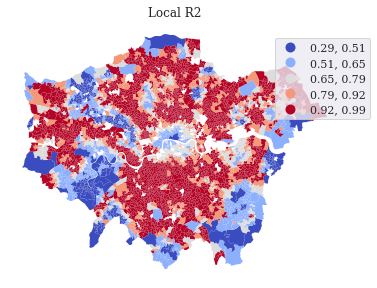

In [86]:
fig, ax = plt.subplots(figsize=(6, 6))
lsoa_gdf.plot(column='gwr_R2', cmap = 'coolwarm', linewidth=0.01, scheme = 'FisherJenks', k=5, legend=True, legend_kwds={'bbox_to_anchor':(1.10, 0.96)},  ax=ax)
ax.set_title('Local R2', fontsize=12)
ax.axis("off")
#plt.savefig('myMap.png',dpi=150, bbox_inches='tight')
plt.show()

In [87]:
lsoa_gdf['gwr_intercept'] = gwr_results.params[:,0]
lsoa_gdf['gwr_White']        = gwr_results.params[:,1]

In [90]:
# Filter t-values: standard alpha = 0.05
gwr_filtered_t = gwr_results.filter_tvals(alpha = 0.05)

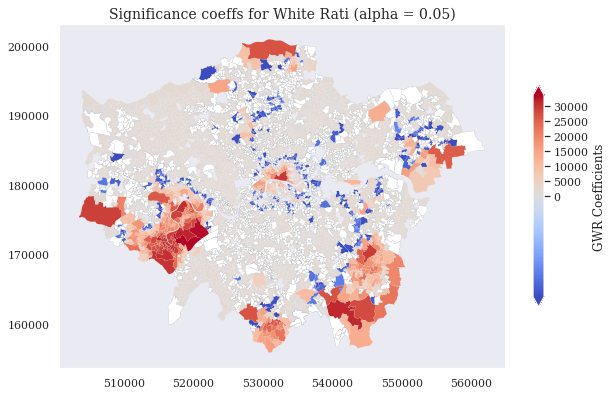

In [91]:
import matplotlib.colors as mcolors
# Use TwoSlopeNorm to set the minimum, center, and maximum values of the color map.
norm = mcolors.TwoSlopeNorm(vmin=lsoa_gdf['gwr_White'].min(), 
                            vcenter=0, 
                            vmax=lsoa_gdf['gwr_White'].max())

# Visualization White Rati Significance Map
fig, ax = plt.subplots(figsize=(10, 8))

lsoa_gdf.plot(column='gwr_White', cmap='coolwarm',linewidth=0.05, legend=True, norm=norm, 
              legend_kwds={
                  'shrink': 0.5,   
                  'label': "GWR Coefficients",  
                  'orientation': "vertical",  
                  'extend': 'both', 
                  'extendfrac': 0.05  
              }, 
              ax=ax)
lsoa_gdf[gwr_filtered_t[:,1] == 0].plot(color='white', linewidth=0.05, edgecolor='black', ax=ax)
# Setting the Chart Title
ax.set_title('Significance coeffs for White Rati (alpha = 0.05)', fontsize=14)
plt.show()

In [ ]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 提取需要的列
data = lsoa_gdf[['White_Rati_Centrality', 'Mixed_Rati_Centrality', 'Asian_Rati_Centrality', 'Black_Rati_Centrality', 'Other_Rati_Centrality', 'White_Rati_Income_Decile','Mixed_Rati_Income_Decile','Black_Rati_Income_Decile','Asian_Rati_Income_Decile','Other_Rati_Income_Decile']].copy()

# 添加常数列用于计算 VIF
data_with_const = sm.add_constant(data)

# 计算 VIF
def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

# 计算并显示 VIF
vif_df = calculate_vif(data_with_const)
print(vif_df)
